#Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import stats

#Utility functions

In [2]:
def set_seeds(seed):
    np.random.seed(seed)


def plot_regret(all_cumulative_regrets, label, T, n_epochs):
    average_cumulative_regret = all_cumulative_regrets.mean(axis=0)
    cumulative_regret_std = all_cumulative_regrets.std(axis=0)

    plt.plot(np.arange(T), average_cumulative_regret, label=label)
    plt.fill_between(np.arange(T),
                    average_cumulative_regret-cumulative_regret_std/np.sqrt(n_epochs),
                    average_cumulative_regret+cumulative_regret_std/np.sqrt(n_epochs),
                    alpha=0.3)
    plt.legend()

    plt.show()

def solve_linear_program(f, ct, rho):
    c = -f
    A_ub = [ct]
    b_ub = [rho]
    A_eq = [np.ones(len(f))]
    b_eq = [1]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    return res.x, -res.fun



def get_clairvoyant_truthful(B, my_valuation, lam, m_t, n_users):
    ## I compute my sequence of utilities at every round
    payment = m_t*lam
    utility = ((my_valuation*lam) - payment)*(my_valuation>=m_t)
    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0
    i = 0
    while c <= B-1 and i < n_users:
        clairvoyant_bids[sorted_round_utility[i]] = my_valuation
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = payment[sorted_round_utility[i]]
        c += payment[sorted_round_utility[i]]
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

def get_clairvoyant_OPT(my_valuation, ctr, B, n_users, m_t, available_bids, lambdas):

      ''' compute for each possible bid a weighted lambda using all the lambdas
          with the weight given as the ratio in which the bid surpass the first maximum, second maximum and so on '''
      my_valuations = np.array([])
      lambdas_b = np.array([])
      for b in available_bids:
          lambda_b = 0
          count = 0
          y = np.count_nonzero(b*ctr > m_t[0])
          for i in range(len(lambdas)):
              x = np.count_nonzero(b*ctr >= m_t[i]);
              if(i != 0):
                 x -= y
                 y = x
              count += x
              lambda_b += x*lambdas[i]
          if (count != 0):
              lambda_b = lambda_b/count
          my_valuations = np.append(my_valuations, my_valuation*lambda_b*ctr)
          lambdas_b = np.append(lambdas_b, b*lambda_b*ctr)

      '''solve the linear program '''
      win_probabilities = np.array([sum(b*ctr >= m_t[len(lambdas) - 1])/n_users for b in available_bids])
      f = (my_valuations-lambdas_b)*win_probabilities
      ct = lambdas_b*win_probabilities
      rho = B/n_users
      gamma, value = solve_linear_program(f, ct, rho)
      expected_clairvoyant_utilities = [value for u in range(n_users)]
      expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]
      return expected_clairvoyant_bids, expected_clairvoyant_utilities




def get_bidding_adversarial_sequence(n_competitors, n_users, alpha, beta):
    bids = lambda n_competitors, a, b: np.random.uniform(a, b, n_competitors)
    a_s = np.random.beta(alpha, beta, n_users)/2
    b_s = 1 - np.random.beta(alpha, beta, n_users)/2

    bids_sequence = [bids(n_competitors, a_s[i], b_s[i]) for i in range(n_users)]
    bids_sequence = np.array(bids_sequence)

    return bids_sequence

def get_pricing_adversarial_sequence(prices, max_visits, n_days, alpha, beta):
    conversion_probability = lambda p, theta: 1-theta*p
    thetas = np.random.beta(alpha, beta, n_days)

    demands_t_p_n = [[[
        np.random.binomial(n=i+1, p=conversion_probability(price, thetas[k]))
        for i in range(max_visits)]
        for price in  prices]
        for k in range(n_days)]
    return demands_t_p_n



#Auctions

In [3]:
# Base Auction class
class Auction:
    def __init__(self, click_through_rates, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism
        payments_per_click = self.get_payments_per_click(winners, values, bids) # payment rule
        return winners, payments_per_click

    def get_click_through_rates(self):
        return self.click_through_rates

# Truthful Auctions
class SecondPriceAuction(Auction):
    def __init__(self, click_through_rates, lambdas):
        self.lambdas = lambdas
        self.click_through_rates = click_through_rates
        self.n_advertisers = len(self.click_through_rates)

    def get_winners(self, bids):
        advertisers_values = self.click_through_rates * bids
        advertisers_ranking = np.argsort(advertisers_values)
        winner = advertisers_ranking[-1]
        return [winner], advertisers_values

    def get_payments_per_click(self, winners, values, bids):
        advertisers_ranking = np.argsort(values)
        second_winner = advertisers_ranking[-2]
        payment = values[second_winner] / self.click_through_rates[winners[0]]
        return [payment.round(2)]

#VCGAuction
class VCGAuction(Auction):
    def __init__(self, click_through_rates, lambdas):
        self.click_through_rates = click_through_rates
        self.lambdas = lambdas
        self.n_advertisers = len(self.click_through_rates)
        self.n_slots = len(self.lambdas)

    def get_winners(self, bids):
        advertisers_values = self.click_through_rates * bids
        advertisers_ranking = np.argsort(advertisers_values)
        winners = advertisers_ranking[-self.n_slots:]
        winners_values = advertisers_values[winners]
        return winners, winners_values

    def get_payments_per_click(self, winners, values, bids):
        payments_per_click = np.zeros(self.n_slots)
        for i, winner in enumerate(winners):
            Y = sum(np.delete(values, i) * self.lambdas[-self.n_slots + 1:])
            X = sum(np.delete(values * self.lambdas, i))
            payments_per_click[i] = (Y - X) / (self.lambdas[i] * self.click_through_rates[winner])
        return payments_per_click.round(2)

# Non-Truthful Auctions
class FirstPriceAuction(Auction):
    def __init__(self, click_through_rates, lambdas):
        self.lambdas = lambdas
        self.click_through_rates = click_through_rates
        self.n_advertisers = len(self.click_through_rates)

    def get_winners(self, bids):
        advertisers_values = self.click_through_rates * bids
        advertisers_ranking = np.argsort(advertisers_values)
        winner = advertisers_ranking[-1]
        return winner, advertisers_values

    def get_payments_per_click(self, winners, values, bids):
        payment = bids[winners]
        return payment.round(2)

class GeneralizedFirstPriceAuction(Auction):
    def __init__(self, click_through_rates, lambdas):
        self.click_through_rates = click_through_rates
        self.lambdas = lambdas
        self.n_advertisers = len(self.click_through_rates)
        self.n_slots = len(self.lambdas)

    def get_winners(self, bids):
        advertisers_values = self.click_through_rates * bids
        advertisers_ranking = np.argsort(advertisers_values)
        winners = advertisers_ranking[-self.n_slots:]
        winners = winners[::-1]
        winners_values = advertisers_values[winners]
        return np.array(winners), winners_values

    def get_payments_per_click(self, winners, values, bids):
        payments_per_click = np.array(bids)[winners]
        return [payment.round(2) for payment in payments_per_click]

#Agents

In [4]:
# Base Agent class
class Agent:
    def __init__(self):
        pass

    def pull_arm(self):
        pass

    def update(self, reward_t):
        pass


# Stochastic MABs
class RandomAgent(Agent):
    def __init__(self, K, T, seed):
        np.random.seed(seed)
        self.action_sequence = np.random.choice(np.arange(K), size=T)
        self.action_t = None
        self.action_history = np.array([])
        self.t = 0

    def pull_arm(self):
        self.action_t = self.action_sequence[self.t]
        return self.action_t

    def update(self, reward_t):
        self.action_history = np.append(self.action_history, self.action_t)
        self.t += 1

class GreedyAgent:
    def __init__(self, K, T):
        self.K = K
        self.T = T
        self.action_t = None
        self.average_rewards = np.inf * np.ones(K)
        self.n_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.action_t = np.argmax(self.average_rewards)
        return self.action_t

    def update(self, reward_t):
        self.n_pulls[self.action_t] += 1
        if self.n_pulls[self.action_t] == 1:
            self.average_rewards[self.action_t] = reward_t
        else:
            self.average_rewards[self.action_t] += (reward_t - self.average_rewards[self.action_t]) / self.n_pulls[self.action_t]
        self.t += 1

class ETCAgent(Agent):
    def __init__(self, K, T, T0):
        self.K = K
        self.T = T
        self.T0 = T0
        self.action_t = None
        self.average_rewards = np.zeros(K)
        self.n_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        if self.t <= self.T0 * self.K:
            self.action_t = self.t % self.K
        else:
            self.action_t = np.argmax(self.average_rewards)

        return self.action_t

    def update(self, reward_t):
        self.n_pulls[self.action_t] += 1
        if self.t <= self.T0 * self.K:
            self.average_rewards[self.action_t] += (reward_t - self.average_rewards[self.action_t]) / self.n_pulls[self.action_t]
        self.t += 1

class UCB1Agent(Agent):
    def __init__(self, K, T, range=1, anytime=False):
        self.K = K
        self.T = T
        self.range = range
        self.anytime = anytime
        self.action_t = None
        self.average_rewards = np.zeros(K)
        self.n_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        if self.t < self.K:
            self.action_t = self.t
        else:
            if self.anytime:
                ucb_values = self.average_rewards + self.range * np.sqrt(2 * np.log(self.t) / self.n_pulls)
            else:
                ucb_values = self.average_rewards + self.range * np.sqrt(2 * np.log(self.T) / self.n_pulls)
            self.action_t = np.argmax(ucb_values)
        return self.action_t

    def update(self, reward_t):
        self.n_pulls[self.action_t] += 1
        self.average_rewards[self.action_t] += (reward_t - self.average_rewards[self.action_t]) / self.n_pulls[self.action_t]
        self.t += 1

class TSAgent(Agent):
    def __init__(self, K):
        self.K = K
        self.action_t = None
        self.n_pulls = np.zeros(K)
        self.alpha, self.beta = np.ones(K), np.ones(K)

    def pull_arm(self):
        theta = np.random.beta(self.alpha, self.beta)
        self.action_t = np.argmax(theta)
        return self.action_t

    def update(self, reward_t):
        self.alpha[self.action_t] += reward_t
        self.beta[self.action_t] += 1 - reward_t
        self.n_pulls[self.action_t] += 1


# Adversarial MABs
class HedgeAgent(Agent):
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K) / K # normalized weights (initial uniform distribution)
        self.action_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights / self.weights.sum()
        self.action_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.action_t

    def update(self, loss_t):
        self.weights *= np.exp(-self.learning_rate * loss_t)
        self.t += 1

class EXP3Agent(Agent):
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K) / K
        self.action_t = None
        self.n_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights / self.weights.sum()
        self.action_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.action_t

    def update(self, loss_t):
        loss_t_adjusted = loss_t / self.x_t[self.action_t]
        self.weights[self.action_t] *= np.exp(-self.learning_rate * loss_t_adjusted)
        self.n_pulls[self.action_t] += 1
        self.t += 1


# PRICING AGENTS

# Base Pricing Agent class
class PricingAgent:
    def __init__(self):
        pass

    def set_price(self):
        pass

    def update(self, reward_t):
        pass

# Pricing Agent with prices discretized and bandit feedback
class EXP3PricingAgent(PricingAgent):
    def __init__(self, prices, T):
        self.prices = prices
        self.K = len(prices)
        learning_rate = np.sqrt(np.log(self.K)/(self.K*T))

        self.exp3_agent = EXP3Agent(self.K, learning_rate)


    def set_price(self):
        return self.prices[self.exp3_agent.pull_arm()]

    def update(self, reward_t):
        self.exp3_agent.update(1-reward_t)


# Gaussian Process based agents
class GPUCBAgent(PricingAgent):
    # From the agent's POV, the action set is [0,1]. If the actual actions are outside this
    # set, we can always perform a rescaling outside the class.

    def __init__(self, T, discretization=100, scale=1):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale).fit()
        self.action_t = None
        self.action_history = np.array([])
        self.reward_history = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t + 1) ** 2
        self.beta = lambda t: 1 + 0.5 * np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.n_pulls = np.zeros(discretization)
        self.t = 0

    def set_price(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms)
        ucbs = self.mu_t + self.beta(self.t) * self.sigma_t
        self.action_t = np.argmax(ucbs) # index of the price the agent chooses
        return self.arms[self.action_t] # returns the price the agent chooses

    def update(self, reward_t):
        self.n_pulls[self.action_t] += 1
        self.action_history = np.append(self.action_history, self.arms[self.action_t])
        self.reward_history = np.append(self.reward_history, reward_t)
        self.gp = self.gp.fit(self.arms[self.action_t], reward_t)
        self.t += 1

class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)

    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()


# BIDDING AGENTS

# Base Bidding Agent class
class BiddingAgent:
    def __init__(self):
        pass

    def bid(self):
        pass

    def update(self, f_t, c_t, m_t=None):
        pass

class UCBBiddingAgent:
    def __init__(self, available_bids, budget, T):
        self.available_bids = available_bids
        self.budget = budget
        self.T = T

        self.rho = self.budget/self.T
        self.action_t = None
        self.average_utilities = np.zeros(len(available_bids))
        self.average_costs = np.zeros(len(available_bids))
        self.n_pulls = np.zeros(len(available_bids))
        self.t = 0

    def bid(self):
        if self.budget < 1:
            self.action_t = 0

        elif self.t < len(self.available_bids):
            self.action_t = self.t

        else:
             ucb_utility_values = self.average_utilities + np.sqrt(2 * np.log(self.T) / self.n_pulls)
             ucb_cost_values = self.average_costs - np.sqrt(2 * np.log(self.T) / self.n_pulls)
             gamma, fun = solve_linear_program(ucb_utility_values, ucb_cost_values, self.rho)

             self.action_t = np.random.choice(range(len(self.available_bids)), p=gamma)

        return self.available_bids[self.action_t]

    def update(self, f_t, c_t, m_t=None):
        self.n_pulls[self.action_t] += 1
        self.average_utilities[self.action_t] += (f_t - self.average_utilities[self.action_t]) / self.n_pulls[self.action_t]
        self.average_costs[self.action_t] += (c_t - self.average_costs[self.action_t]) / self.n_pulls[self.action_t]
        self.t += 1
        self.budget -= c_t


class MultiplicativePacingAgent(BiddingAgent):
    def __init__(self, valuation, budget, T, learning_rate=0.1):
        self.valuation = valuation
        self.budget = budget
        self.T = T
        self.learning_rate = learning_rate
        self.rho = self.budget / self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation / (self.lmbd + 1)

    def update(self, f_t, c_t, m_t=None):
        self.lmbd = np.clip(self.lmbd - self.learning_rate * (self.rho - c_t), a_min=0, a_max=1/self.rho)
        self.budget -= c_t

class FFMultiplicativePacingAgent(BiddingAgent):
    def __init__(self, bids_set, valuation, ctr, budget, T, learning_rate):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K) / T)) # learning rate from theory
        self.valuation = valuation
        self.ctr = ctr
        self.budget = budget
        self.T = T
        self.learning_rate = learning_rate
        self.rho = self.budget / self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t, c_t, m_t):
        # Update the Hedge agent
        f_t_full = np.array([((self.valuation * self.ctr) - (b * self.ctr)) * int(b*self.ctr >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*self.ctr * int(b*self.ctr >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd * (c_t_full - self.rho)
        L_range = 2 + (1 - self.rho) / self.rho
        self.hedge.update((2 - L) / L_range) # Hedge needs losses in [0,1]

        # Update the Lagrangian multiplier
        self.lmbd = np.clip(self.lmbd - self.learning_rate * (self.rho - c_t), a_min=0, a_max=1/self.rho)

        # Update the budget
        self.budget -= c_t

#Environments

In [5]:
# Base Environment class
class Environment:
    def __init__(self):
        pass

    def round(self, action_t):
        pass

# Environments for stochastic and adversarial bandits
class BernoulliEnvironment(Environment):
    def __init__(self, probs, T, seed=None):
        np.random.seed(seed)
        self.K = len(probs)
        self.rewards = np.random.binomial(n=1, p=probs, size=(T, self.K)) # T x K matrix: rewards[t][k] is the reward of action k at time t
        self.t = 0

    def round(self, action_t):
        reward_t = self.rewards[self.t][action_t]
        self.t += 1
        return reward_t

class BinomialEnvironment(Environment):
    def __init__(self, probs, T, interval_range, seed=None):
        np.random.seed(seed)
        self.K = len(probs)
        self.rewards = np.random.binomial(n=interval_range, p=probs, size=(T, self.K))
        self.t = 0

    def round(self, action_t):
        reward_t = self.rewards[self.t][action_t]
        self.t += 1
        return reward_t

class GreedyEnvironment(Environment):
    def __init__(self, T, seed=None):
        np.random.seed(seed)
        self.probs = np.array([0.5, 0.25])
        self.K = len(self.probs)
        self.rewards = np.zeros((T, self.K))
        self.rewards[0, 0] = 0
        self.rewards[1:, 0] = np.random.binomial(n=1, p=self.probs[0], size=T-1)
        self.rewards[:, 1] = self.probs[1]
        self.t = 0

    def round(self, action_t):
        reward_t = self.rewards[self.t, action_t]
        self.t += 1
        return reward_t

class AdversarialExpertEnvironment(Environment):
    def __init__(self, loss_sequence):
        self.loss_sequence = loss_sequence
        self.t = 0

    def round(self):                        # no need for a specific arm, the learner observes the loss of every action each round
        loss_t = self.loss_sequence[self.t] # we return the whole loss vector
        self.t += 1
        return loss_t

class AdversarialBanditEnvironment(Environment):
    def __init__(self, loss_sequence):
        self.loss_sequence = loss_sequence
        self.t = 0

    def round(self, action_t):                          # we need to receive a specific arm
        loss_t = self.loss_sequence[self.t, action_t]   # we only return the loss of the chosen arm
        self.t += 1
        return loss_t

# Environment for pricing problems
class PricingEnvironment:
    def __init__(self):
        pass

    def round(self, price_t, n_t):
        pass

class StochasticPricingEnvironment(PricingEnvironment):
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, price_t, n_t):
        demand_t = np.random.binomial(n=n_t, p=self.conversion_probability(price_t))
        reward_t = demand_t * (price_t - self.cost)
        return demand_t, reward_t

class AdversarialPricingEnvironment(PricingEnvironment):
    def __init__(self, demands_t_p_n, cost, T, prices):
        self.prices = prices
        self.demands_t_p_n = demands_t_p_n
        self.cost = cost
        self.T = T
        self.t = 0

    def round(self, price_t, n_t):
        i_price = -1
        for i in range(len(self.prices)):
            if(self.prices[i] == price_t):
               i_price = i
        demand_t = self.demands_t_p_n[self.t][i_price][n_t-1]
        reward_t = demand_t * (price_t - self.cost)
        self.t += 1
        return demand_t, reward_t

# Competitors for the auction problem
class Competitors:

    def __init__(self, *args, **kwargs):
        pass

    def get_bids(self):
        pass

class StochasticCompetitors(Competitors):

    def __init__(self, n_competitors, distribution):

        self.n_competitors = n_competitors
        self.distribution = distribution

    def get_bids(self):

        # Sample bids from the distribution
        bids = self.distribution(self.n_competitors)

        # Get the maximum bid
        m_t = np.max(bids)
        index_max = np.argmax(bids) + 1

        return bids, m_t, index_max

class AdversarialCompetitors(Competitors):

    def __init__(self, bids_sequence, T):

        self.bids_sequence = bids_sequence
        self.T = T
        self.t = 0

    def get_bids(self):

        bids = self.bids_sequence[self.t, :]

        # Get the maximum bid
        m_t = np.max(bids)
        index_max = np.argmax(bids) + 1

        self.t += 1

        return bids, m_t, index_max

#Interactions classes (Company, Publlisher, Interaction)

In [6]:
''' Company class '''
class Company:

    def __init__(self, pricing_agent, bidding_agent, valuation, ctr, product_cost):

        self.pricing_agent = pricing_agent
        self.bidding_agent = bidding_agent
        self.valuation = valuation
        self.product_cost = product_cost
        self.ctr = ctr

    def set_price(self):

        return self.pricing_agent.set_price()

        # Here add the changes if we consider the value depend on the price, assigning a new value to the valuation variable

    def bid(self):

        return self.bidding_agent.bid()


    def update_pricing_strategy(self, purchase_reward):

        self.pricing_agent.update(purchase_reward)

    def update_bidding_strategy(self, auction_results):

        # Compute utility and cost
        f_t, c_t = self._compute_utility_and_cost(auction_results)
        m_t = auction_results['m_t']

        # Update bidding strategy
        self.bidding_agent.update(f_t, c_t, m_t)

        return f_t, c_t

    def _compute_utility_and_cost(self, auction_results):

        #payment could be m_t in case of truthful auction, or the bid itself in case of non truthful auctions
        win = auction_results['company_win']
        payment = auction_results['company_payment']
        l = auction_results["company_slot_lambda"]

        # Compute utility
        f_t = ((self.ctr * self.valuation * l)  - (self.ctr * l * payment)) * win

        # Compute cost
        c_t = (self.ctr * l * payment) * win

        return f_t, c_t

'''This class includes the logic of the specific auctions and return the results for the company for each round'''
class Publisher:

    # The company index is always 0, as the company bid is the first one
    COMPANY_INDEX = 0

    def __init__(self, auction):

        self.auction = auction


    def round(self, bid, competitor_bids, m_t, index_max):

        # Append the competitor bids to the company's bid
        bids = np.append(bid, competitor_bids)

        # Run the auction
        winners, payments_per_click = self.auction.round(bids)

        # Check if the company won the auction, and if so, the slot in which the ad was shown
        company_win = self.COMPANY_INDEX in winners
        company_slot = -1
        company_payment = 0
        if company_win:
            for i in range(len(winners)):
                if winners[i] == self.COMPANY_INDEX:
                    company_slot = i
                    break
            company_payment = payments_per_click[company_slot]

        # Get the company's click through rate
        ctrs = self.auction.get_click_through_rates()
        company_ctr = ctrs[self.COMPANY_INDEX]

        # Simulate the click outcome (True if the user clicked on the ad) only if the company actually won some slot
        click_outcome = False

        if company_win:
            click_outcome = np.random.rand() < company_ctr

        auction_results = {
            'company_win': company_win,
            'company_slot_lambda': self.auction.lambdas[company_slot],
            'company_payment': company_payment,
            'm_t': m_t*self.auction.click_through_rates[index_max]
        }

        return auction_results, click_outcome

''' Interaction class '''
class Interaction:
    def __init__(self, company, publisher, competitors, pricing_environment):
        self.company = company
        self.publisher = publisher
        self.competitors = competitors
        self.pricing_environment = pricing_environment

        # Logging variables
        self.m_t = np.array([])
        self.bidding_agent_utilities = np.array([])
        self.bidding_agent_payments = np.array([])
        self.bidding_agent_bids = np.array([])
        self.pricing_agent_rewards = np.array([])
        self.visits_per_day = []

    def simulates_n_days(self, n_days, users_per_day):
        # Simulates n_days of interaction

        for i in range(n_days):
            self._day(users_per_day[i])

        # return necessary data for computing clairvoyant and plotting results
        return self.bidding_agent_utilities, self.m_t, self.pricing_agent_rewards, self.visits_per_day

    def _day(self, n_users):
        # Simulates a day, made up of multiple auctions

        # Company sets a price and initialize a counter of visits
        price = self.company.set_price()
        n_visits = 0

        # Company faces a series of auctions
        for user in range(n_users):
            # Company and Competitors bids
            bid = self.company.bid()
            competitor_bids, m_t_round, index_max = self.competitors.get_bids()

            # Publisher runs the auction and simulates the click outcome
            auction_results, click_outcome = self.publisher.round(bid, competitor_bids, m_t_round, index_max)

            # Update the company's bidding strategy and get utility and payment of the company for this round
            f_t, c_t = self.company.update_bidding_strategy(auction_results)

            # Increment counter of visits if user clicked on the ad
            if click_outcome:
                n_visits += 1

            # Logging
            self.bidding_agent_bids = np.append(self.bidding_agent_bids, bid)
            self.bidding_agent_utilities = np.append(self.bidding_agent_utilities, f_t)
            self.bidding_agent_payments = np.append(self.bidding_agent_payments, c_t)
            self.m_t = np.append(self.m_t, auction_results['m_t'])

        # Get the reward for this day for the pricing agent
        if (n_visits == 0):
            n_visits = 1
        demand_t, reward_t = self.pricing_environment.round(price, n_visits)

        # Update the company's pricing strategy
        pricing_reward = reward_t/n_visits
        self.company.update_pricing_strategy(pricing_reward)

        # Logging
        self.pricing_agent_rewards = np.append(self.pricing_agent_rewards, pricing_reward)
        self.visits_per_day.append(n_visits)


#Requirement 1

In [7]:
''' Requirement 1 classes '''
class Requirement1:
    def __init__(self, params, n_trials):
        # Parameters of the problem
        self.n_days = params["n_days"]
        self.users_per_day = params["users_per_day"]
        self.ctrs = params["ctrs"]
        self.lambdas = params["lambdas"]
        self.valuation = params["valuation"]
        self.product_cost = params["product_cost"]
        self.budget = params["budget"]
        self.bidding_agent_type= params["ucb_bidding_agent"]
        self.n_trials = n_trials





    '''INTERACTION PRICING AND BIDDING'''
    def run(self):
        ''' DEFINE THE STOCHASTIC COMPONENTS'''
        # Define a conversion probability function
        conversion_probability = lambda p: 1-p

        # Define a distribution over the bids (uniform)
        distribution = lambda n_competitors: np.random.uniform(0, 1, n_competitors)

        # The first ctr is the one of the company
        n_competitors = len(self.ctrs)-1

        # Number of users for  the bidding algorithm accross all days
        n_users = np.sum(self.users_per_day)

        ''' COMPUTE THE TWO CLAIRVOYANTS'''

        # Compute the pricing clairvoyant
        K = int(1/(self.n_days**(-1/3)))  # discretization as prescribed by the theory
        min_price, max_price = 0, 1
        reward_function = lambda price, n_sales: (price-self.product_cost)*n_sales

        prices = np.linspace(min_price, max_price, K)
        profit_curve = reward_function(prices, conversion_probability(prices))
        best_price_index = np.argmax(profit_curve)
        expected_pricing_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], self.n_days)

        '''# Compute the bidding clairvoyant
        #The distribution of the max of k uniform random variables is a beta variable with alpha = k and beta = 1, expected_value = alpha/beta+alpha
        m_t = [n_competitors/(1 + n_competitors) for i in range(n_users)]
        m_t = np.array(m_t)

        # 1) Compute it greedily (only in truthful auctions)
        expected_bidding_clairvoyant_bids, expected_bidding_clairvoyant_utilities, expected_bidding_clairvoyant_payments = get_clairvoyant_truthful(self.budget, self.valuation, m_t, n_users)

        # 2) Compute it by solving the linear program
        win_probabilities = stats.beta.cdf(available_bids, n_competitors, 1)
        expected_bidding_clairvoyant_bids, expected_bidding_clairvoyant_utilities = get_clairvoyant_OPT(self.valuation, self.budget, n_users, win_probabilities, available_bids)

        since neither of those two worked the computation is done by using the true m_t vectors in the loop below
        '''

        ''' DEFINE THE LOGGING VARIABLE AND START THE TRIALS'''

        available_bids = np.linspace(0,1,int(1/(n_users**(-1/3))))
        pricing_all_cumulative_regret = []
        bidding_all_cumulative_regret = []


        for i in range(self.n_trials):
            '''DEFINE THE COMPANY'''

            # Define the pricing agent
            pricing_agent = GPUCBAgent(self.n_days, K)

            # Define the bidding agent
            if (not self.bidding_agent_type):
                bidding_agent = MultiplicativePacingAgent( self.valuation , self.budget, n_users)
            else:
                bidding_agent = UCBBiddingAgent( available_bids, self.budget, n_users)

            company = Company(pricing_agent, bidding_agent, self.valuation , self.ctrs[0] , self.product_cost)


            '''DEFINE THE PUBLISHER I.E. THE AUCTION TYPE (IN THIS CASE A TRUTHFUL AUCTION)'''

            # Define the auction type
            auction = SecondPriceAuction(self.ctrs, self.lambdas)

            publisher = Publisher(auction)


            '''DEFINE THE STOCHASTIC ENVIRONMENT I.E. THE STOCHASTIC COMPETITORS AND THE STOCHASTIC PRICING ENVIRONMENT'''


            pricing_environment = StochasticPricingEnvironment(conversion_probability, self.product_cost)


            competitors = StochasticCompetitors(n_competitors, distribution)

            ''' START THE INTERACTION'''

            interaction = Interaction(company, publisher, competitors, pricing_environment)

            bidding_agent_utilities, m_t, pricing_agent_rewards, visits_per_day = interaction.simulates_n_days(self.n_days, self.users_per_day)


            ''' COMPUTE THE BIDDING CLAIRVOYANT FOR THIS TRIAL'''
            expected_bidding_clairvoyant_bids, expected_bidding_clairvoyant_utilities, expected_bidding_clairvoyant_payments = get_clairvoyant_truthful(self.budget, self.valuation * self.ctrs[0] , self.lambdas[0], m_t, n_users)

            ''' LOGGING '''
            pricing_all_cumulative_regret.append(np.cumsum(expected_pricing_clairvoyant_rewards - pricing_agent_rewards))
            bidding_all_cumulative_regret.append(np.cumsum(expected_bidding_clairvoyant_utilities - bidding_agent_utilities))

        pricing_all_cumulative_regret = np.array(pricing_all_cumulative_regret)
        bidding_all_cumulative_regret = np.array(bidding_all_cumulative_regret)


        ''' PLOT THE AVERAGE REGRETS OF THE PRICING AND BIDDING AGENT'''
        plot_regret(pricing_all_cumulative_regret, "Pricing GPUCB Agent Average Regret", self.n_days, self.n_trials)

        if (self.bidding_agent_type):
            type_of_bidding_agent = "UCB-like"
        else:
            type_of_bidding_agent = "Multiplicative Pacing"

        plot_regret(bidding_all_cumulative_regret, f"Bidding {type_of_bidding_agent} Agent Average Regret", n_users, self.n_trials)



















    '''ONLY BIDDING'''
    def run_bidding(self):
        ''' DEFINE THE  COMPONENTS'''

        # Define a distribution over the bids (uniform)
        distribution = lambda n_competitors: np.random.uniform(0, 1, n_competitors)

        # The first ctr is the one of the company
        n_competitors = len(self.ctrs)-1

        # Number of users for  the bidding algorithm accross all days
        n_users = np.sum(self.users_per_day)


        ''' DEFINE THE LOGGING VARIABLE AND START THE TRIALS'''

        available_bids = np.linspace(0,1,int(1/(n_users**(-1/3))))

        bidding_all_cumulative_regret = []


        def compute_utility_and_cost(auction_results):

            #payment could be m_t in case of truthful auction, or the bid itself in case of non truthful auctions
            win = auction_results['company_win']
            payment = auction_results['company_payment']
            l = auction_results["company_slot_lambda"]

            # Compute utility
            f_t = ((self.ctrs[0] * self.valuation * l)  - (self.ctrs[0] * l * payment)) * win

            # Compute cost
            c_t = (self.ctrs[0] * l * payment) * win

            return f_t, c_t



        for i in range(self.n_trials):

            # Define the bidding agent
            if (not self.bidding_agent_type):
                bidding_agent = MultiplicativePacingAgent( self.valuation , self.budget, n_users)
            else:
                bidding_agent = UCBBiddingAgent( available_bids, self.budget, n_users)



            '''DEFINE THE PUBLISHER I.E. THE AUCTION TYPE (IN THIS CASE A TRUTHFUL AUCTION)'''

            # Define the auction type
            auction = SecondPriceAuction(self.ctrs, self.lambdas)

            publisher = Publisher(auction)


            '''DEFINE THE STOCHASTIC COMPETITORS '''


            competitors = StochasticCompetitors(n_competitors, distribution)

            ''' START THE INTERACTION'''

            m_t = np.array([])
            bidding_agent_bids = np.array([])
            bidding_agent_utilities = np.array([])
            bidding_agent_payments = np.array([])
            # Company faces a series of auctions
            for user in range(n_users):
                # Company and Competitors bids
                bid = bidding_agent.bid()
                competitor_bids, m_t_round, index_max = competitors.get_bids()

                # Publisher runs the auction and simulates the click outcome
                auction_results, click_outcome = publisher.round(bid, competitor_bids, m_t_round, index_max)

                # Update the bidding strategy and get utility and payment of the company for this round

                # Compute utility and cost
                f_t, c_t = compute_utility_and_cost(auction_results)
                m_t_round = auction_results['m_t']

                # Update bidding strategy
                bidding_agent.update(f_t, c_t, m_t_round)


                # Logging
                bidding_agent_bids = np.append(bidding_agent_bids, bid)
                bidding_agent_utilities = np.append(bidding_agent_utilities, f_t)
                bidding_agent_payments = np.append(bidding_agent_payments, c_t)
                m_t = np.append(m_t, auction_results['m_t'])




            ''' COMPUTE THE BIDDING CLAIRVOYANT FOR THIS TRIAL'''
            expected_bidding_clairvoyant_bids, expected_bidding_clairvoyant_utilities, expected_bidding_clairvoyant_payments = get_clairvoyant_truthful(self.budget, self.valuation * self.ctrs[0] , self.lambdas[0], m_t, n_users)

            ''' LOGGING '''
            bidding_all_cumulative_regret.append(np.cumsum(expected_bidding_clairvoyant_utilities - bidding_agent_utilities))

        bidding_all_cumulative_regret = np.array(bidding_all_cumulative_regret)


        ''' PLOT THE AVERAGE REGRETS OF THE BIDDING AGENT'''

        if (self.bidding_agent_type):
            type_of_bidding_agent = "UCB-like"
        else:
            type_of_bidding_agent = "Multiplicative Pacing"

        plot_regret(bidding_all_cumulative_regret, f"Bidding {type_of_bidding_agent} Agent Average Regret", n_users, self.n_trials)









    ''' ONLY PRICING'''
    def run_pricing(self, n_customers):
        ''' DEFINE THE STOCHASTIC COMPONENTS'''
        # Define a conversion probability function
        conversion_probability = lambda p: 1-p


        ''' COMPUTE THE CLAIRVOYANT'''

        # Compute the pricing clairvoyant
        K = int(1/(self.n_days**(-1/3)))  # discretization as prescribed by the theory
        min_price, max_price = 0, 1
        reward_function = lambda price, n_sales: (price-self.product_cost)*n_sales

        prices = np.linspace(min_price, max_price, K)
        profit_curve = reward_function(prices, n_customers * conversion_probability(prices))
        best_price_index = np.argmax(profit_curve)
        expected_pricing_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], self.n_days)


        ''' DEFINE THE LOGGING VARIABLE AND START THE TRIALS'''

        pricing_all_cumulative_regret = []

        def rescale(x, min_x, max_x):
                return min_x + (max_x-min_x)*x


        for i in range(self.n_trials):

            # Define the pricing agent
            pricing_agent = GPUCBAgent(self.n_days, K)



            '''DEFINE THE STOCHASTIC PRICING ENVIRONMENT'''


            pricing_environment = StochasticPricingEnvironment(conversion_probability, self.product_cost)


            ''' START THE INTERACTION'''


            agent_rewards = np.array([])
            for t in range(self.n_days):
                p_t = pricing_agent.set_price()
                p_t = rescale(p_t, min_price, max_price)
                d_t, r_t = pricing_environment.round(p_t, n_t=n_customers)
                pricing_agent.update(r_t/n_customers)
                agent_rewards = np.append(agent_rewards, r_t)

            ''' LOGGING '''
            pricing_all_cumulative_regret.append(np.cumsum(expected_pricing_clairvoyant_rewards - agent_rewards))

        pricing_all_cumulative_regret = np.array(pricing_all_cumulative_regret)



        ''' PLOT THE AVERAGE REGRETS OF THE PRICING AGENT'''
        plot_regret(pricing_all_cumulative_regret, "Pricing GPUCB Agent Average Regret", self.n_days, self.n_trials)


#Requirement 2

In [8]:
''' Requirement 2 classes '''
class Requirement2:
    def __init__(self, params, n_trials):
        # Parameters of the problem
        self.n_days = params["n_days"]
        self.users_per_day = params["users_per_day"]
        self.ctrs = params["ctrs"]
        self.lambdas = params["lambdas"]
        self.valuation = params["valuation"]
        self.product_cost = params["product_cost"]
        self.budget = params["budget"]
        self.n_trials = n_trials







    '''INTERACTION PRICING AND BIDDING'''
    def run(self):
        # Discretized prices
        K = int(1/(self.n_days**(-1/3)))  # discretization as prescribed by the theory
        min_price, max_price = 0, 1
        prices = np.linspace(min_price, max_price, K)

        # The first ctr is the one of the company
        n_competitors = len(self.ctrs)-1

        # Number of users for  the bidding algorithm accross all days
        n_users = np.sum(self.users_per_day)

        # Discretized bids for the adversarial problem
        available_bids = np.linspace(0,1,int(1/(n_users**(-1/3))))


        ''' DEFINE THE ADVERSARIAL COMPONENTS'''
        # Define the sequence of demands for each day, price and number of visits demands_t_p_n
        max_visits = np.max(self.users_per_day)
        demands_t_p_n = get_pricing_adversarial_sequence(prices, max_visits, self.n_days, 1, 1)

        # Define the adversarial sequence of bids of the competitors
        bids_sequence = get_bidding_adversarial_sequence(n_competitors, n_users, 1, 1)


        ''' COMPUTE THE TWO CLAIRVOYANTS'''

        # Compute the pricing clairvoyant

        reward_function = lambda price, n_sales: (price-self.product_cost)*n_sales


        # Compute the bidding clairvoyant


        # Compute it by solving the linear program
        # Sort each row in descending order
        bids_seq = np.sort(bids_sequence, axis=1)[:, ::-1]
        max_indices = np.argsort(bids_sequence, axis=1)[:, ::-1]
        # Extract maxima
        m_t = []
        for i in range(len(self.lambdas)):
            ctr_max = np.array([self.ctrs[i+1] for i in max_indices[:, i]])
            m_t.append(bids_seq[:, i]*ctr_max)
        m_t = np.array(m_t)
        expected_bidding_clairvoyant_bids, expected_bidding_clairvoyant_utilities = get_clairvoyant_OPT(self.valuation , self.ctrs[0], self.budget, n_users, m_t, available_bids, self.lambdas)



        ''' DEFINE THE LOGGING VARIABLE AND START THE TRIALS'''

        pricing_all_cumulative_regret = []
        bidding_all_cumulative_regret = []


        for i in range(self.n_trials):
            '''DEFINE THE COMPANY'''

            # Define the pricing agent
            pricing_agent = EXP3PricingAgent(prices, self.n_days)

            # Define the bidding agent
            learning_rate = 1/np.sqrt(n_users)
            bidding_agent = FFMultiplicativePacingAgent(available_bids, self.valuation, self.ctrs[0], self.budget, n_users, learning_rate)


            company = Company(pricing_agent, bidding_agent, self.valuation, self.ctrs[0], self.product_cost)


            '''DEFINE THE PUBLISHER I.E. THE AUCTION TYPE (IN THIS CASE A NON-TRUTHFUL AUCTION)'''

            # Define the auction type
            auction = GeneralizedFirstPriceAuction(self.ctrs, self.lambdas)

            publisher = Publisher(auction)


            '''DEFINE THE ADVERSARIAL ENVIRONMENT I.E. THE ADVERSARIAL COMPETITORS AND THE ADVERSARIAL PRICING ENVIRONMENT'''


            pricing_environment = AdversarialPricingEnvironment(demands_t_p_n, self.product_cost, self.n_days, prices)


            competitors = AdversarialCompetitors(bids_sequence, n_users)

            ''' START THE INTERACTION'''

            interaction = Interaction(company, publisher, competitors, pricing_environment)

            bidding_agent_utilities, m_t, pricing_agent_rewards, visits_per_day = interaction.simulates_n_days(self.n_days, self.users_per_day)


            ''' COMPUTE THE PRICING CLAIRVOYANT FOR THIS TRIAL'''

            demands_t_p = [[
                (demands_t_p_n[i][j][visits_per_day[i]-1])/visits_per_day[i]
                for j in range(len(prices))]
                for i in range(self.n_days)]

            loss_curve_t = 1 - np.array([np.array(reward_function(prices, np.array(demands_t_p[i]))) for i in range(self.n_days)])

            # Best arm(price) in hindsight
            best_arm = np.argmin(loss_curve_t.sum(axis=0))
            expected_pricing_clairvoyant_losses = loss_curve_t[:, best_arm]

            ''' LOGGING '''
            pricing_all_cumulative_regret.append(np.cumsum((1 - pricing_agent_rewards) - expected_pricing_clairvoyant_losses))
            bidding_all_cumulative_regret.append(np.cumsum(expected_bidding_clairvoyant_utilities - bidding_agent_utilities))


        pricing_all_cumulative_regret = np.array(pricing_all_cumulative_regret)
        bidding_all_cumulative_regret = np.array(bidding_all_cumulative_regret)


        ''' PLOT THE AVERAGE REGRETS OF THE PRICING AND BIDDING AGENT'''
        plot_regret(pricing_all_cumulative_regret, "Pricing EXP3 Agent Average Regret", self.n_days, self.n_trials)


        plot_regret(bidding_all_cumulative_regret, "Bidding FFMultiplicativePacing Agent Average Regret", n_users, self.n_trials)













    '''ONLY BIDDING'''
    def run_bidding(self):


        # The first ctr is the one of the company
        n_competitors = len(self.ctrs)-1

        # Number of users for  the bidding algorithm accross all days
        n_users = np.sum(self.users_per_day)

        # Discretized bids for the adversarial problem
        available_bids = np.linspace(0,1,int(1/(n_users**(-1/3))))


        ''' DEFINE THE ADVERSARIAL COMPONENTS'''
        # Define the adversarial sequence of bids of the competitors
        bids_sequence = get_bidding_adversarial_sequence(n_competitors, n_users, 1, 1)


        ''' COMPUTE THE CLAIRVOYANT'''

        # Compute the bidding clairvoyant


        # Compute it by solving the linear program
        # Sort each row in descending order
        bids_seq = np.sort(bids_sequence, axis=1)[:, ::-1]
        max_indices = np.argsort(bids_sequence, axis=1)[:, ::-1]
        # Extract maxima
        m_t = []
        for i in range(len(self.lambdas)):
            ctr_max = np.array([self.ctrs[i+1] for i in max_indices[:, i]])
            m_t.append(bids_seq[:, i]*ctr_max)
        m_t = np.array(m_t)
        expected_bidding_clairvoyant_bids, expected_bidding_clairvoyant_utilities = get_clairvoyant_OPT(self.valuation , self.ctrs[0], self.budget, n_users, m_t, available_bids, self.lambdas)



        ''' DEFINE THE LOGGING VARIABLE AND START THE TRIALS'''

        bidding_all_cumulative_regret = []

        def compute_utility_and_cost(auction_results):

            #payment could be m_t in case of truthful auction, or the bid itself in case of non truthful auctions
            win = auction_results['company_win']
            payment = auction_results['company_payment']
            l = auction_results["company_slot_lambda"]

            # Compute utility
            f_t = ((self.ctrs[0] * self.valuation * l)  - (self.ctrs[0] * l * payment)) * win

            # Compute cost
            c_t = (self.ctrs[0] * l * payment) * win

            return f_t, c_t


        for i in range(self.n_trials):

            # Define the bidding agent
            learning_rate = 1/np.sqrt(n_users)
            bidding_agent = FFMultiplicativePacingAgent(available_bids, self.valuation, self.ctrs[0], self.budget, n_users, learning_rate)



            '''DEFINE THE PUBLISHER I.E. THE AUCTION TYPE (IN THIS CASE A NON-TRUTHFUL AUCTION)'''

            # Define the auction type
            auction = GeneralizedFirstPriceAuction(self.ctrs, self.lambdas)

            publisher = Publisher(auction)


            '''DEFINE THE ADVERSARIAL ENVIRONMENT I.E. THE ADVERSARIAL COMPETITORS '''

            competitors = AdversarialCompetitors(bids_sequence, n_users)

            ''' START THE INTERACTION'''



            bidding_agent_utilities = np.array([])

            # Company faces a series of auctions
            for user in range(n_users):
                # Company and Competitors bids
                bid = bidding_agent.bid()
                competitor_bids, m_t_round, index_max = competitors.get_bids()

                # Publisher runs the auction and simulates the click outcome
                auction_results, click_outcome = publisher.round(bid, competitor_bids, m_t_round, index_max)

                # Update the bidding strategy and get utility and payment of the company for this round

                # Compute utility and cost
                f_t, c_t = compute_utility_and_cost(auction_results)
                m_t_round = auction_results['m_t']

                # Update bidding strategy
                bidding_agent.update(f_t, c_t, m_t_round)


                # Logging

                bidding_agent_utilities = np.append(bidding_agent_utilities, f_t)




            ''' LOGGING '''

            bidding_all_cumulative_regret.append(np.cumsum(expected_bidding_clairvoyant_utilities - bidding_agent_utilities))


        bidding_all_cumulative_regret = np.array(bidding_all_cumulative_regret)


        ''' PLOT THE AVERAGE REGRETS OF THE BIDDING AGENT'''


        plot_regret(bidding_all_cumulative_regret, "Bidding FFMultiplicativePacing Agent Average Regret", n_users, self.n_trials)















    ''' ONLY PRICING'''
    def run_pricing(self, n_customers):

        # Discretized prices
        K = int(1/(self.n_days**(-1/3)))  # discretization as prescribed by the theory
        min_price, max_price = 0, 1
        prices = np.linspace(min_price, max_price, K)


        ''' DEFINE THE ADVERSARIAL COMPONENTS'''
        # Define the sequence of demands for each day, price and number of visits demands_t_p_n
        demands_t_p_n = get_pricing_adversarial_sequence(prices, n_customers, self.n_days, 1, 1)



        # Reward function for the pricing problem

        reward_function = lambda price, n_sales: (price-self.product_cost)*n_sales


        ''' DEFINE THE LOGGING VARIABLE AND START THE TRIALS'''

        pricing_all_cumulative_regret = []

        def rescale(x, min_x, max_x):
                return min_x + (max_x-min_x)*x



        for i in range(self.n_trials):


            # Define the pricing agent
            pricing_agent = EXP3PricingAgent(prices, self.n_days)


            '''DEFINE THE ADVERSARIAL PRICING ENVIRONMENT'''


            pricing_environment = AdversarialPricingEnvironment(demands_t_p_n, self.product_cost, self.n_days, prices)


            ''' START THE INTERACTION'''

            pricing_agent_rewards = np.array([])
            for t in range(self.n_days):
                p_t = pricing_agent.set_price()
                p_t = rescale(p_t, min_price, max_price)
                d_t, r_t = pricing_environment.round(p_t, n_t=n_customers)
                pricing_agent.update(r_t/n_customers)
                pricing_agent_rewards = np.append(pricing_agent_rewards, r_t/n_customers)


            ''' COMPUTE THE PRICING CLAIRVOYANT FOR THIS TRIAL'''

            demands_t_p = [[
                (demands_t_p_n[i][j][n_customers-1])/n_customers
                for j in range(len(prices))]
                for i in range(self.n_days)]

            loss_curve_t = 1 - np.array([np.array(reward_function(prices, np.array(demands_t_p[i]))) for i in range(self.n_days)])

            # Best arm(price) in hindsight
            best_arm = np.argmin(loss_curve_t.sum(axis=0))
            expected_pricing_clairvoyant_losses = loss_curve_t[:, best_arm]

            ''' LOGGING '''
            pricing_all_cumulative_regret.append(np.cumsum((1 - pricing_agent_rewards) - expected_pricing_clairvoyant_losses))


        pricing_all_cumulative_regret = np.array(pricing_all_cumulative_regret)


        ''' PLOT THE AVERAGE REGRETS OF THE PRICING AGENT'''
        plot_regret(pricing_all_cumulative_regret, "Pricing EXP3 Agent Average Regret", self.n_days, self.n_trials)











#Simulations

##Parameters

In [9]:
n_days = 500
users_per_day = [10 for i in range(n_days)] #20 users per day
ctrs = [0.8, 0.5, 0.9, 1] # company + competitors
lambdas = [1, 0.9] # 2 slots
budget = 1000
product_cost = 0.1
valuation = 1
ucb_bidding_agent = True  #if true then the bidding agent is ucb-like, else it is multiplicative pacing

n_trials = 10


problem_params = {"n_days" : n_days, "users_per_day" : users_per_day, "ctrs" : ctrs, "lambdas" : lambdas,
                  "ucb_bidding_agent" : ucb_bidding_agent, "budget" : budget, "product_cost" : product_cost, "valuation" : valuation}

set_seeds(100)

##Requirement 1

###Only pricing

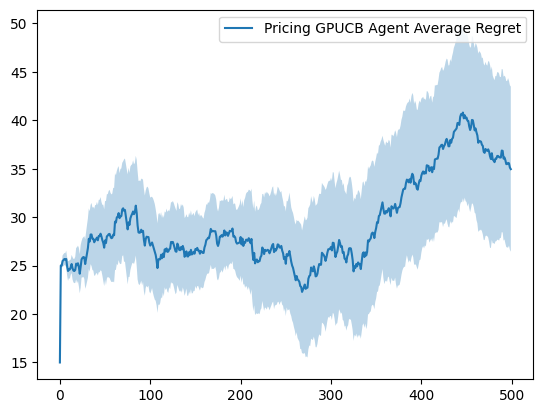

In [10]:
n_customers = 50
req = Requirement1(problem_params, n_trials)
req.run_pricing(n_customers)

### Only bidding

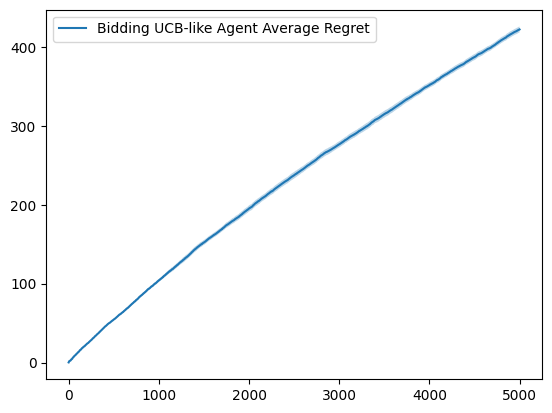

In [11]:
#UCB-LIKE BIDDING AGENT
problem_params["ucb_bidding_agent"] = True
req = Requirement1(problem_params, n_trials)
req.run_bidding()

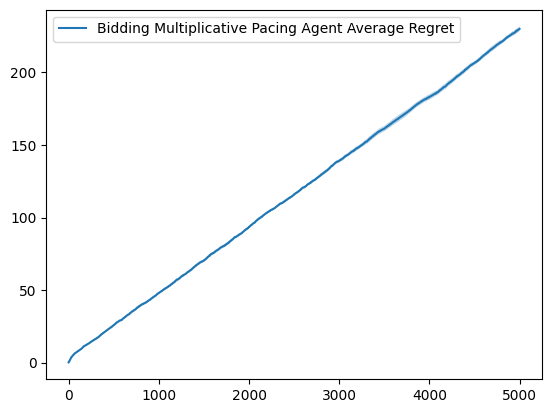

In [12]:
#MULTIPLICATIVE PACING BIDDING AGENT
problem_params["ucb_bidding_agent"] = False
req = Requirement1(problem_params, n_trials)
req.run_bidding()

### Complete Interaction (Bidding and Pricing)

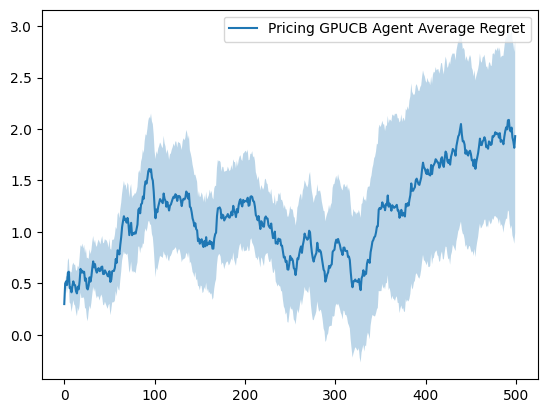

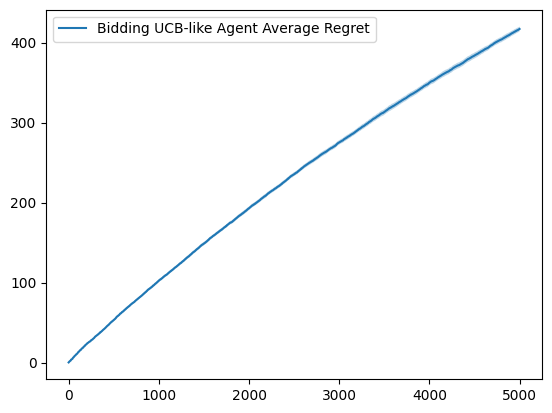

In [13]:
#UCB-LIKE BIDDING AGENT
problem_params["ucb_bidding_agent"] = True
req = Requirement1(problem_params, n_trials)
req.run()

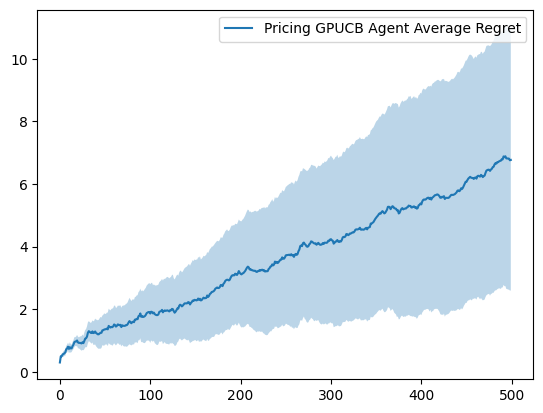

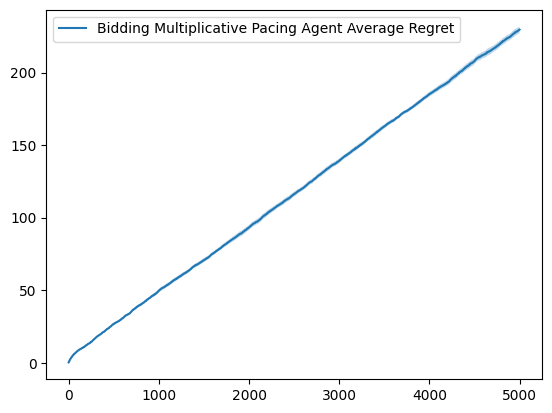

In [14]:
#MULTIPLICATIVE PACING BIDDING AGENT
problem_params["ucb_bidding_agent"] = False
req = Requirement1(problem_params, n_trials)
req.run()

##Requirement 2

###Only pricing

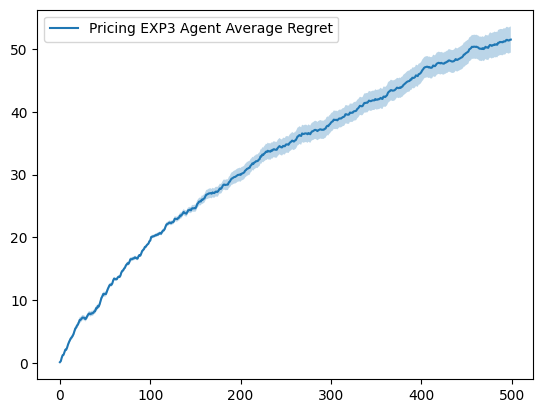

In [15]:
n_customers = 50
req = Requirement2(problem_params, n_trials)
req.run_pricing(n_customers)

### Only bidding

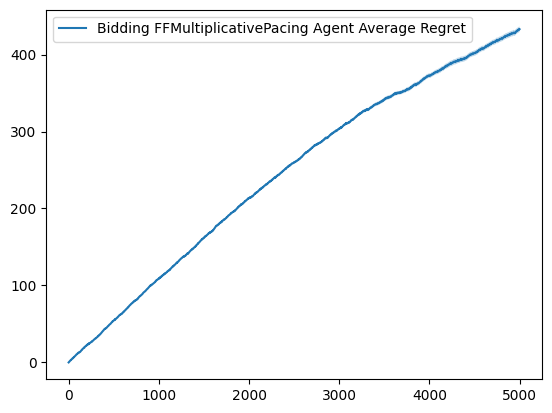

In [16]:
req = Requirement2(problem_params, n_trials)
req.run_bidding()

###Complete Interaction (Bidding and Pricing)

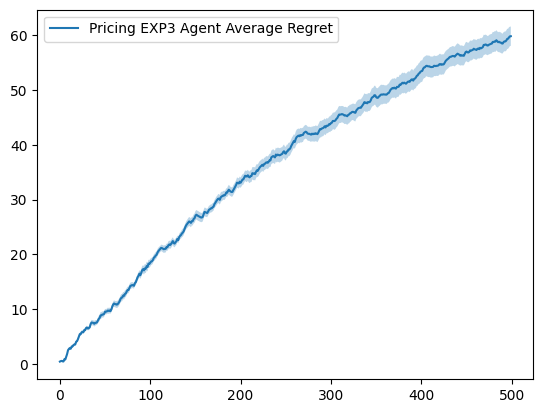

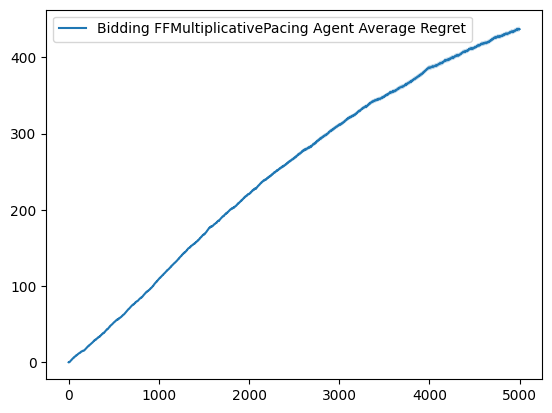

In [17]:
req = Requirement2(problem_params, n_trials)
req.run()